# Best valued players per 'player type'

We first cluster players based on a few key attributes, then assess the reason for grouping (e.g. attacking players who score a lot, players who create a lot of chances for others, etc)

Then, we find the best valued player (cheapest player) per category / cluster

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [108]:
players = pd.read_csv('../CurrentSeasonData/Players_with_teams_positions.csv', index_col=0)

In [109]:
## Check player attributes that can be useful for the clustering
players.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'player_id',
       'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo',
       'points_per_game', 'second_name', 'selected_by_percent', 'special',
       'squad_number', 'status', 'team', 'team_code', 'total_points',
       'transfers_in', 'transfers_in_event', 'transfers_out',
       'transfers_out_event', 'value_form', 'value_season', 'web_name',
       'region', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'starts', 'expected_goals',
       'expected_assists', 'expected_goal_involvements',
  

## Dealing with NAs

In [110]:
## Standard cleaning -- remove cols with too many NAs
na_df = pd.DataFrame(players.select_dtypes(include=[np.number]).isna().sum(axis=0).sort_values(ascending=False), columns=['Missing values'])
na_df[(na_df['Missing values'] > 0)]

,Missing values
squad_number,324
corners_and_indirect_freekicks_text,324
direct_freekicks_text,324
penalties_text,324
penalties_order,281
direct_freekicks_order,279
corners_and_indirect_freekicks_order,266
chance_of_playing_this_round,129
chance_of_playing_next_round,122


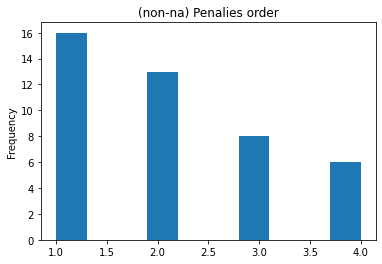

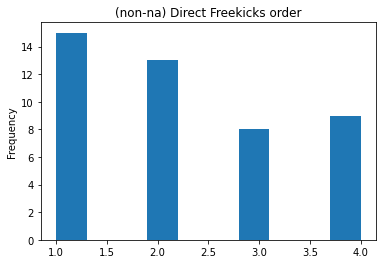

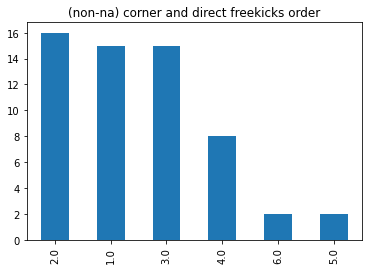

In [111]:
players.penalties_order.plot(kind = 'hist', title = '(non-na) Penalies order')
plt.show()
players.direct_freekicks_order.plot(kind = 'hist',title = '(non-na) Direct Freekicks order')
plt.show()
players.corners_and_indirect_freekicks_order.value_counts().plot(kind = 'bar',title = '(non-na) corner and direct freekicks order')
plt.show()

Most values for the order metrics are NA. However, if we drop them, we lose out on important information that determines points (e.g. penalty takers get more points than non pen takers). 

We can arbitraily set the value for players who are not considered for these set pieces to be a large value. This is tricky, but we can stick to setting the value to 10 - intuitively they come after the very last considered player for the set pieces, but beause they are not considered at all, there is some distance to separate them from the considered players.

In [112]:
order_cols = [col for col in na_df.index if col.endswith('order')]
print(order_cols)

## Set na values here to 10 
players[order_cols] = players[order_cols].fillna(10)

['penalties_order', 'direct_freekicks_order', 'corners_and_indirect_freekicks_order']


In [113]:
## Drop the other cols: 
drop_cols = set(na_df[(na_df['Missing values'] > 0)].index.tolist()) - set(order_cols)
print(drop_cols)

players.drop(columns=drop_cols, inplace=True)


{'chance_of_playing_next_round', 'squad_number', 'corners_and_indirect_freekicks_text', 'chance_of_playing_this_round', 'direct_freekicks_text', 'penalties_text'}


In [114]:
## Check: nas should be gone
## Standard cleaning -- remove cols with too many NAs
na_df = pd.DataFrame(players.select_dtypes(include=[np.number]).isna().sum(axis=0).sort_values(ascending=False), columns=['Missing values'])
na_df[(na_df['Missing values'] > 0)]

,Missing values


# Method 1: use PCA on all variables (doesnt require feature selection) + KMeans for clustering 

Benefits
* PCA - dimensionality reduction (deals with correlated variables)
* removes redundancy
* helps to visualise the clustering after it's done

In [115]:
numeric_cols = players.select_dtypes(include=[np.number]).columns
## check
print(f'{len(numeric_cols)}/{players.shape[1]} of columns are numeric')

82/93 of columns are numeric


In [116]:
## Which are the non-numeric ones, and can we coerce them? 
non_numeric_cols = set(players.columns) - set(numeric_cols)
print(non_numeric_cols)

{'team_name', 'second_name', 'position', 'news', 'status', 'web_name', 'news_added', 'first_name', 'in_dreamteam', 'special', 'photo'}


Indeed, apart from poistion, we will not use them for the quantitative methods. 

## Aside: are positions 'encoded' in attributes data? 

1. Qualitative visualisation via PCA/t-SNE

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Standard preprocessing 
numeric_X = players[numeric_cols].values

## Scale 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_X)

In [118]:
## RUN THE PCA 
## CHOOSE N_COMPONENTS = 2 FOR VISUALISATION

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)
## Append pcs to data -- we need to use positions from data to observe 
players_pca = players[['position']]
players_pca['pc1'] = X_pca_2[:, 0]
players_pca['pc2'] = X_pca_2[:, 1]


/tmp/ipykernel_336856/2214188570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_pca['pc1'] = X_pca_2[:, 0]
/tmp/ipykernel_336856/2214188570.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_pca['pc2'] = X_pca_2[:, 1]


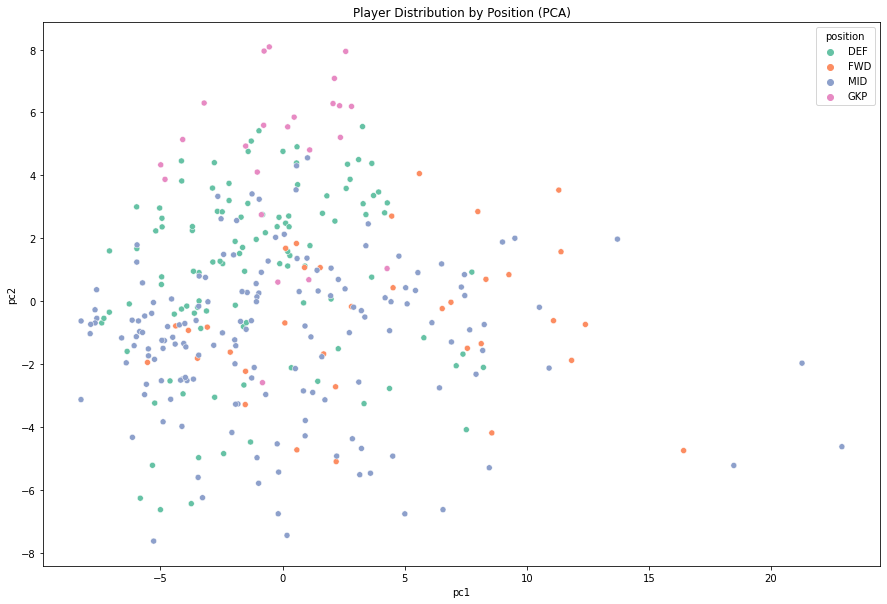

In [119]:
## Viusalise
import seaborn as sns
plt.figure(figsize=(15,10))
sns.scatterplot(data=players_pca, x='pc1', y='pc2', hue='position', palette='Set2')
plt.title('Player Distribution by Position (PCA)')
plt.show()

There is some separation between positions, but not very clear, and there are overlaps between Mid/Forwards. Let us combine those two groups

/tmp/ipykernel_336856/1900713965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_pca['position2']= players_pca.position.map({'MID':'MID/FWD', 'FWD':'MID/FWD', 'DEF': 'DEF', 'GKP': 'GKP'})


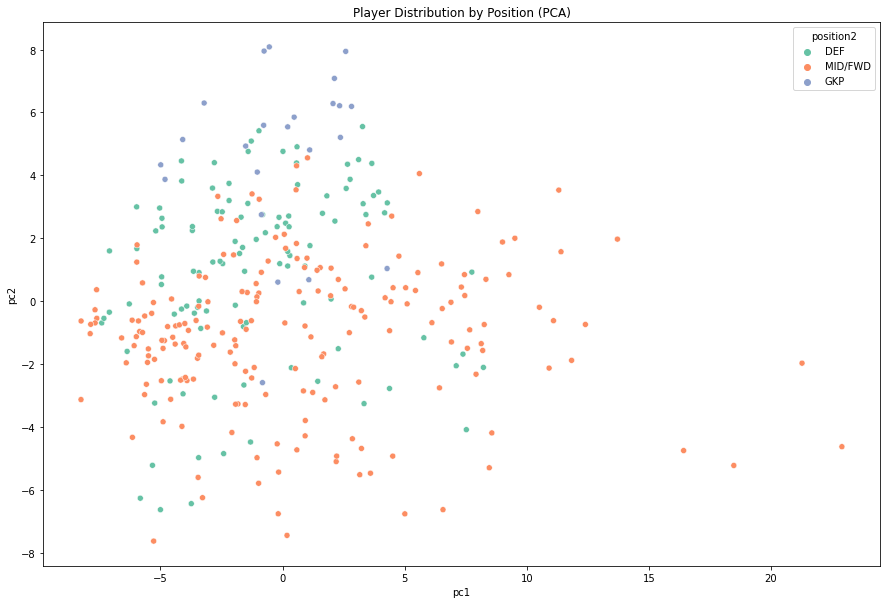

In [122]:
import seaborn as sns
plt.figure(figsize=(15,10))
players_pca['position2']= players_pca.position.map({'MID':'MID/FWD', 'FWD':'MID/FWD', 'DEF': 'DEF', 'GKP': 'GKP'})
sns.scatterplot(data=players_pca, x='pc1', y='pc2', hue='position2', palette='Set2')
plt.title('Player Distribution by Position (PCA)')
plt.show()

There is some information embedded in the attributes that differentiates players based on positions.

## Continue with method 1

We have to reduce the large dimension down to a smaller one now. 

Let us choose a minimal amount of dimensions (PCs) that capture most information about a player's style, e.g. capturing more than 75% variance.

In [126]:
## Remove cost
numeric_cols_minus_cost = [col for col in numeric_cols if 'cost' not in col]
numeric_X_minus_cost = players[numeric_cols_minus_cost].values


In [127]:
## Scale 
scaler = StandardScaler()
X_scaled_no_cost = scaler.fit_transform(numeric_X_minus_cost)

## PCA 
pca_all = PCA(n_components=None) ## get all pcs
X_pca_all = pca_all.fit_transform(X_scaled_no_cost)


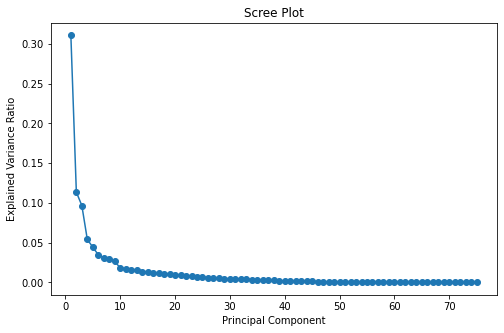

In [128]:
## Check explained variance 
# Explained variance ratio for each PC
explained_variance = pca_all.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

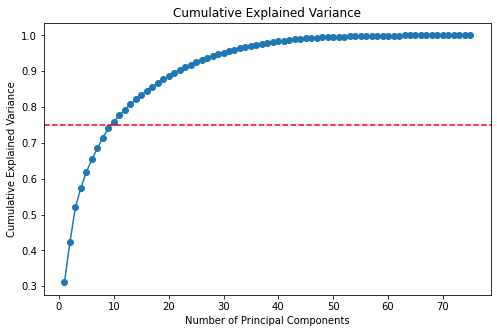

In [131]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.75, color='r', linestyle='--')  # example: 90% threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [135]:
np.argmax(cumulative_variance > .75)


9

In [139]:
## Choose the number of components for 75%
n_comps = np.argmax(cumulative_variance)

## Ideal pca -- get the new dimensions
X_pca_final = X_pca_all[:, :n_comps]

## Visualise the current state using t-SNE with some default/simple values for hyperparameters

/home/itan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


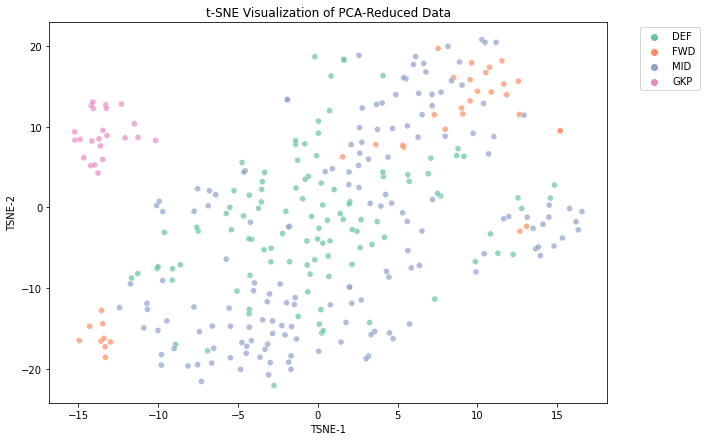

In [141]:
## Visaulise the t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

X_tsne = tsne.fit_transform(X_pca_final)

# If you have labels or classes for each point (e.g., player positions),
# you can color by them. Otherwise, just plot them as is.

# Example: If 'players' DataFrame has a 'position' column
positions = players['position']  # adjust to your actual variable names

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=positions, palette='Set2', alpha=0.7)
plt.title('t-SNE Visualization of PCA-Reduced Data')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see at least 2 or 3 distinct groups, but the center has a lot of players who are uniformly simialar to each other...

Let us decide on **5 groups** of clusters

## KMeans: 5 groups

In [142]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Run K-Means with chosen number of clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_final)

# Add cluster assignments to the players DataFrame
players['cluster'] = cluster_labels


### Insights into the KMeans clustering

In [145]:
# 1. Position Distribution by Cluster
position_distribution = players.groupby('cluster')['position'].value_counts().unstack(fill_value=0)
print("Position Distribution by Cluster:")
print(position_distribution/position_distribution.sum(axis=0))



Position Distribution by Cluster:
position       DEF       FWD       GKP       MID
cluster                                         
0         0.148148  0.057143  0.043478  0.139241
1         0.472222  0.314286  0.000000  0.278481
2         0.333333  0.228571  0.000000  0.449367
3         0.046296  0.400000  0.000000  0.132911
4         0.000000  0.000000  0.956522  0.000000


In [147]:
print("\nExample Players in Each Cluster:")
for c in range(k):
    cluster_players = players[players['cluster'] == c]
    # Print top 5 players by some metric, e.g., influence
    # Adjust this part as needed
    top_in_cluster = cluster_players.sort_values('influence', ascending=False).head(5)
    print(f"\nCluster {c}:")
    print(top_in_cluster[['first_name', 'second_name', 'position', 'influence', 'creativity', 'threat']])



Example Players in Each Cluster:

Cluster 0:
    first_name      second_name position  influence  creativity  threat
65      Virgil         van Dijk      DEF      332.6        70.9   130.0
148     Thomas           Partey      MID      270.8       162.2    94.0
245      Mateo          Kovačić      MID      245.4       243.7   104.0
62    Ibrahima           Konaté      DEF      228.8        46.9    65.0
69       Rúben  Gato Alves Dias      DEF      220.8       119.1    69.0

Cluster 1:
   first_name                second_name position  influence  creativity  \
18     Nathan                    Collins      DEF      482.6        63.1   
37       Marc                      Guéhi      DEF      421.0        95.7   
19      Ethan                    Pinnock      DEF      412.4        97.4   
49    Antonee                   Robinson      DEF      376.6       242.2   
84    Murillo  Santiago Costa dos Santos      DEF      366.4       121.1   

    threat  
18   197.0  
37   126.0  
19   181.0  
4

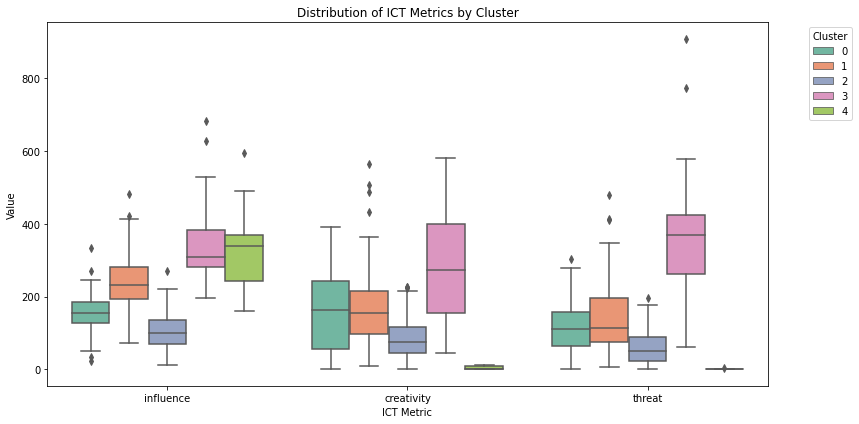

In [148]:

# Melt the ICT features for easier plotting
ict_columns = ['influence', 'creativity', 'threat']
ict_melt = players.melt(id_vars='cluster', value_vars=ict_columns, var_name='ICT_metric', value_name='value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=ict_melt, x='ICT_metric', y='value', hue='cluster', palette='Set2')
plt.title('Distribution of ICT Metrics by Cluster')
plt.xlabel('ICT Metric')
plt.ylabel('Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# BEST / CHEAPEST PLAYER PER CLUSTER

In [150]:
players['name'] = players['first_name'] + ' ' + players.second_name
players['value_for_money'] = players['total_points'] / players['now_cost']

print("Most Value for Money Player in Each Cluster:")
for c in range(k):
    cluster_players = players[players['cluster'] == c]
    # Find the player with the max value_for_money in this cluster
    best_player = cluster_players.loc[cluster_players['value_for_money'].idxmax()]
    print(f"\nCluster {c}:")
    print(f"Name: {best_player['name']}")
    print(f"Position: {best_player['position']}")
    print(f"Total Points: {best_player['total_points']}")
    print(f"Now Cost: {best_player['now_cost']}")
    print(f"Value for Money: {best_player['value_for_money']:.2f}")

Most Value for Money Player in Each Cluster:

Cluster 0:
Name: Virgil van Dijk
Position: DEF
Total Points: 64
Now Cost: 64
Value for Money: 1.00

Cluster 1:
Name: Ashley Young
Position: DEF
Total Points: 57
Now Cost: 46
Value for Money: 1.24

Cluster 2:
Name: Álex Moreno Lopera
Position: DEF
Total Points: 30
Now Cost: 44
Value for Money: 0.68

Cluster 3:
Name: Chris Wood
Position: FWD
Total Points: 88
Now Cost: 65
Value for Money: 1.35

Cluster 4:
Name: Matz Sels
Position: GKP
Total Points: 62
Now Cost: 47
Value for Money: 1.32
